In [342]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from scipy import signal
from sklearn.preprocessing import Normalizer

In [410]:
pd.options.display.float_format = "{:,.7f}".format
np.set_printoptions(suppress=True)

In [344]:
connection = sqlite3.connect('../data/GBPUSD.db')
df = pd.read_sql_query("SELECT * FROM d_2010", connection, parse_dates=True)

In [345]:
std_coef = 10**7

In [346]:
df.head()

,pTime,pOpen,pHigh,pLow,pClose,vcOpen,vcHigh,vcLow,vcClose
0,1262304000,1.61763,1.61763,1.61596,1.61698,3.01611,3.01611,-0.82676,1.52038
1,1262305800,1.61698,1.61702,1.61685,1.61695,1.40760,1.51723,1.05129,1.32537
2,1262307600,1.61695,1.61702,1.61685,1.61690,1.04747,1.26089,0.74260,0.89503
3,1262309400,1.61690,1.61700,1.61682,1.61695,1.21473,1.58046,0.92215,1.39760
4,1262311200,1.61689,1.61705,1.61682,1.61695,1.24069,1.93548,0.93672,1.50124


In [347]:
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'vcOpen', 'vcHigh', 'vcLow', 'vcClose']

In [348]:
df = df.drop(['vcOpen', 'vcHigh', 'vcLow', 'vcClose'], axis=1)

In [349]:
df.head()

,Date,Open,High,Low,Close
0,1262304000,1.61763,1.61763,1.61596,1.61698
1,1262305800,1.61698,1.61702,1.61685,1.61695
2,1262307600,1.61695,1.61702,1.61685,1.61690
3,1262309400,1.61690,1.61700,1.61682,1.61695
4,1262311200,1.61689,1.61705,1.61682,1.61695


In [350]:
date_index = df.Date
df = df.drop('Date', axis=1)
df.index = date_index

In [351]:
window = df.head(20)

In [352]:
window.head()

,Open,High,Low,Close
Date,,,,
1262304000,1.61763,1.61763,1.61596,1.61698
1262305800,1.61698,1.61702,1.61685,1.61695
1262307600,1.61695,1.61702,1.61685,1.61690
1262309400,1.61690,1.61700,1.61682,1.61695
1262311200,1.61689,1.61705,1.61682,1.61695


# Calculating mean of 4 features

In [353]:
window_means = pd.DataFrame(window.mean(axis=1), columns=['mean'])

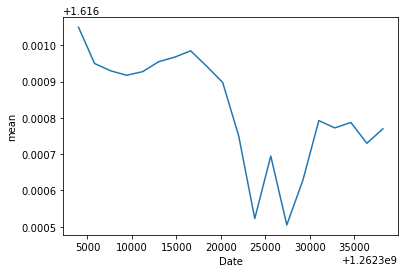

In [354]:
sns.lineplot(data=window_means, y='mean', x='Date');

In [355]:
window_means.head()

,mean
Date,
1262304000,1.61705
1262305800,1.61695
1262307600,1.61693
1262309400,1.61692
1262311200,1.61693


# Find function extremums

In [356]:
means_data = window_means['mean'].values
maximums = signal.argrelextrema(means_data, np.greater)

In [357]:
maximums

(array([ 7, 12, 15, 17], dtype=int64),)

In [358]:
maximums_points = []
maximums_date = []

for maximum in maximums:
    maximums_points.append(means_data[maximum])
    maximums_date.append(window.index[maximum])

In [359]:
maximums_points

[array([1.616985 , 1.616695 , 1.6167925, 1.6167875])]

In [360]:
maximums_date

[Int64Index([1262316600, 1262325600, 1262331000, 1262334600], dtype='int64', name='Date')]

In [361]:
maximums_points = pd.Series(index=maximums_date[0], data=maximums_points[0])

In [362]:
maximums_points

Date
1262316600   1.61699
1262325600   1.61669
1262331000   1.61679
1262334600   1.61679
dtype: float64

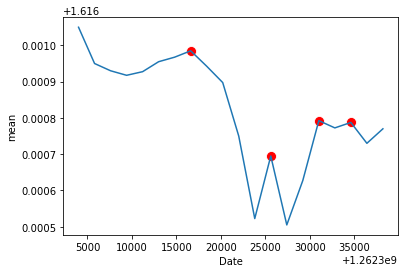

In [363]:
sns.lineplot(data=window_means, y='mean', x='Date')
sns.scatterplot(y=maximums_points.values, x=maximums_points.index, color='r', s=100);

In [364]:
def find_extremums(data, column_name, min_or_max):
    func_values = data[column_name].values
    extremums = signal.argrelextrema(func_values, min_or_max)
    
    extremums_values = []
    extremums_timestamps = []

    for extremum_index in extremums:
        extremums_values.append(func_values[extremum_index])
        extremums_timestamps.append(data.index[extremum_index])
        
    return pd.Series(index=extremums_timestamps[0], data=extremums_values[0])

In [365]:
minimums = find_extremums(window_means, 'mean', np.less)

In [366]:
maximums = find_extremums(window_means, 'mean', np.greater)

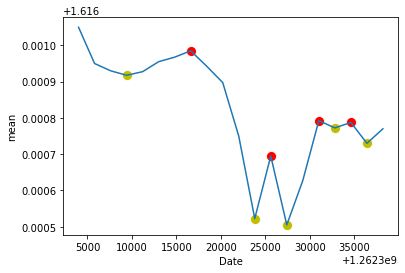

In [367]:
sns.lineplot(data=window_means, y='mean', x='Date')
sns.scatterplot(y=maximums.values, x=maximums.index, color='r', s=100);
sns.scatterplot(y=minimums.values, x=minimums.index, color='y', s=100);

# Calculate mean distance between minimums and maximums

In [368]:
minimums.head()

Date
1262309400   1.61692
1262323800   1.61652
1262327400   1.61651
1262332800   1.61677
1262336400   1.61673
dtype: float64

In [369]:
np.diff(minimums.index).mean()

6750.0

In [370]:
np.diff(maximums.index).mean()

6000.0

# Find derivatives of the mean feature

In [371]:
np.round_((np.diff(window_means['mean']) / np.diff(window_means.index)) * 10**9, 2)

array([ -55.56,  -11.11,   -6.94,    5.56,   15.28,    6.94,    9.72,
        -23.61,  -25.  ,  -81.94, -126.39,   95.83, -105.56,   68.06,
         91.67,  -11.11,    8.33,  -31.94,   22.22])

In [372]:
def get_derivatives(data, y_name):
    return (np.diff(window_means[y_name]) / np.diff(window_means.index))

In [373]:
derivatives = get_derivatives(window_means, 'mean')

In [374]:
derivatives

array([-0.00000006, -0.00000001, -0.00000001,  0.00000001,  0.00000002,
        0.00000001,  0.00000001, -0.00000002, -0.00000003, -0.00000008,
       -0.00000013,  0.0000001 , -0.00000011,  0.00000007,  0.00000009,
       -0.00000001,  0.00000001, -0.00000003,  0.00000002])

In [375]:
derivatives.shape

(19,)

## normalize derivatives

In [376]:
normalizer = Normalizer()
mormalizer = normalizer.fit([derivatives])

In [377]:
normalizer.transform([derivatives])

array([[-0.22203727, -0.04440745, -0.02775466,  0.02220373,  0.06106025,
         0.02775466,  0.03885652, -0.09436584, -0.09991677, -0.32750497,
        -0.50513479,  0.38301429, -0.42187081,  0.27199565,  0.36636149,
        -0.04440745,  0.03330559, -0.12767143,  0.08881491]])

# Identify trend of time series

### Option 1

In [378]:
window_means['mean'].rolling(window=3).mean().head()

Date
1262304000       nan
1262305800       nan
1262307600   1.61698
1262309400   1.61693
1262311200   1.61692
Name: mean, dtype: float64

In [379]:
window_means.index

Int64Index([1262304000, 1262305800, 1262307600, 1262309400, 1262311200,
            1262313000, 1262314800, 1262316600, 1262318400, 1262320200,
            1262322000, 1262323800, 1262325600, 1262327400, 1262329200,
            1262331000, 1262332800, 1262334600, 1262336400, 1262338200],
           dtype='int64', name='Date')

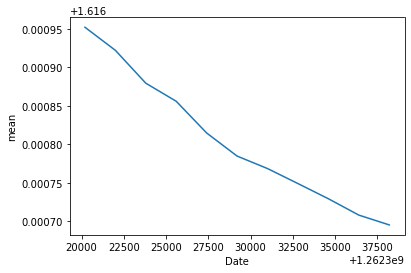

In [380]:
n = 10
trend = window_means['mean'].rolling(window=n).mean().dropna()
sns.lineplot(y=trend, x=window_means.index[n - 1:]);

In [381]:
trend_normalizer = Normalizer()
trend_normalizer = trend_normalizer.fit([trend])
norm_trend = trend_normalizer.transform([trend])

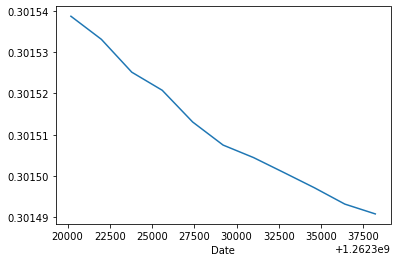

In [382]:
sns.lineplot(y=norm_trend[0], x=window_means.index[n - 1:]);

### Option 2

In [446]:
last_value = window_means['mean'].values[-1]
first_value = window_means['mean'].values[0]

In [447]:
first_timestamp = window_means.index[0]
last_timestamp = window_means.index[-1]

In [448]:
last_timestamp - first_timestamp

34200

In [449]:
last_value - first_value

0.0

**Calculate k coefficient of linear trend**

In [454]:
def calculate_k_coef(x1, y1, x2, y2):
    return (y1 - y2) / (x1 - x2)

In [451]:
calculate_k_coef(first_value, first_timestamp, last_value, last_timestamp)

-0.0

# Assembly final dataset

In [389]:
bars = 20

In [390]:
df.head()

,Open,High,Low,Close
Date,,,,
1262304000,1.61763,1.61763,1.61596,1.61698
1262305800,1.61698,1.61702,1.61685,1.61695
1262307600,1.61695,1.61702,1.61685,1.61690
1262309400,1.61690,1.61700,1.61682,1.61695
1262311200,1.61689,1.61705,1.61682,1.61695


In [391]:
timestamps = df.index

In [464]:
columns = ['timestamp'] + ['deriv_' + str(index) for index in range(19)] + ['trend', 'count_min', 'count_max', 'min_d', 'max_d']
final_dataset = pd.DataFrame(columns=columns)

index = 0
for timestamp in timestamps[:-bars]: #-bars
    window_means = df[df.index > timestamp].head(bars).mean(axis=1)
    window_means = pd.DataFrame(window_means, columns=['mean'])
    
    values = []
    values.append(timestamp)
    values += np.round_(get_derivatives(window_means, 'mean')*10**10).tolist()
    
    first_value, last_value = window_means['mean'].values[0], window_means['mean'].values[-1]
    first_timestamp, last_timestamp = window_means.index[0], window_means.index[-1]
    
    trend_k_coef = round(calculate_k_coef(first_timestamp, first_value, last_timestamp, last_value) * 10**10)
    values.append(trend_k_coef)
    
    minimums = find_extremums(window_means, 'mean', np.less)
    maximums = find_extremums(window_means, 'mean', np.greater)
    
    values.append(minimums.shape[0])
    values.append(maximums.shape[0])
    
    d_minimums = np.diff(minimums.index).mean()
    d_maximums = np.diff(maximums.index).mean()
    
    values.append(d_minimums)
    values.append(d_maximums)
    
    window = pd.DataFrame([values], columns=columns)
    
    final_dataset = final_dataset.append(window, ignore_index=True)

D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: Runt

D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: Runt

D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:26: Runt

D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:26: Runt

D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:26: Runt

D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: Runt

D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: Runt

D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: Runt

D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: Runt

D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: Runt

D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: Runt

D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  re

D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Denis\miniconda\envs\neural-networks\lib\site-packages\ipykernel_launcher.py:25: Runt

In [466]:
final_dataset

,timestamp,deriv_0,deriv_1,deriv_2,deriv_3,deriv_4,deriv_5,deriv_6,deriv_7,deriv_8,...,deriv_14,deriv_15,deriv_16,deriv_17,deriv_18,trend,count_min,count_max,min_d,max_d
0,1262304000,-111.0000000,-69.0000000,56.0000000,153.0000000,69.0000000,97.0000000,-236.0000000,-250.0000000,-819.0000000,...,-111.0000000,83.0000000,-319.0000000,222.0000000,"-1,292.0000000",-121,5,5,"6,750.0000000","5,400.0000000"
1,1262305800,-69.0000000,56.0000000,153.0000000,69.0000000,97.0000000,-236.0000000,-250.0000000,-819.0000000,"-1,264.0000000",...,83.0000000,-319.0000000,222.0000000,"-1,292.0000000",264.0000000,-101,6,5,"6,120.0000000","5,400.0000000"
2,1262307600,56.0000000,153.0000000,69.0000000,97.0000000,-236.0000000,-250.0000000,-819.0000000,"-1,264.0000000",958.0000000,...,-319.0000000,222.0000000,"-1,292.0000000",264.0000000,"1,194.0000000",-34,5,5,"4,050.0000000","5,400.0000000"
3,1262309400,153.0000000,69.0000000,97.0000000,-236.0000000,-250.0000000,-819.0000000,"-1,264.0000000",958.0000000,"-1,056.0000000",...,222.0000000,"-1,292.0000000",264.0000000,"1,194.0000000",-681.0000000,-73,5,6,"4,050.0000000","5,400.0000000"
4,1262311200,69.0000000,97.0000000,-236.0000000,-250.0000000,-819.0000000,"-1,264.0000000",958.0000000,"-1,056.0000000",681.0000000,...,"-1,292.0000000",264.0000000,"1,194.0000000",-681.0000000,-528.0000000,-109,5,6,"4,050.0000000","5,400.0000000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12497,1293795000,"-3,208.0000000","-9,986.0000000","12,569.0000000","9,250.0000000",819.0000000,-153.0000000,"-1,375.0000000","5,569.0000000","16,542.0000000",...,-597.0000000,"-12,597.0000000","-5,500.0000000","-3,167.0000000","11,333.0000000",2279,3,2,"14,400.0000000","12,600.0000000"
12498,1293796800,"-9,986.0000000","12,569.0000000","9,250.0000000",819.0000000,-153.0000000,"-1,375.0000000","5,569.0000000","16,542.0000000","14,750.0000000",...,"-12,597.0000000","-5,500.0000000","-3,167.0000000","11,333.0000000","8,167.0000000",2878,3,2,"14,400.0000000","12,600.0000000"
12499,1293798600,"12,569.0000000","9,250.0000000",819.0000000,-153.0000000,"-1,375.0000000","5,569.0000000","16,542.0000000","14,750.0000000","23,125.0000000",...,"-5,500.0000000","-3,167.0000000","11,333.0000000","8,167.0000000","-1,236.0000000",3338,2,3,"19,800.0000000","13,500.0000000"
12500,1293800400,"9,250.0000000",819.0000000,-153.0000000,"-1,375.0000000","5,569.0000000","16,542.0000000","14,750.0000000","23,125.0000000",69.0000000,...,"-3,167.0000000","11,333.0000000","8,167.0000000","-1,236.0000000","1,986.0000000",2781,3,3,"12,600.0000000","13,500.0000000"


In [467]:
final_dataset.isna().sum()

timestamp      0
deriv_0        0
deriv_1        0
deriv_2        0
deriv_3        0
deriv_4        0
deriv_5        0
deriv_6        0
deriv_7        0
deriv_8        0
deriv_9        0
deriv_10       0
deriv_11       0
deriv_12       0
deriv_13       0
deriv_14       0
deriv_15       0
deriv_16       0
deriv_17       0
deriv_18       0
trend          0
count_min      0
count_max      0
min_d        246
max_d        229
dtype: int64

In [471]:
final_dataset = final_dataset.fillna(0)

In [474]:
final_dataset.isna().sum()

timestamp    0
deriv_0      0
deriv_1      0
deriv_2      0
deriv_3      0
deriv_4      0
deriv_5      0
deriv_6      0
deriv_7      0
deriv_8      0
deriv_9      0
deriv_10     0
deriv_11     0
deriv_12     0
deriv_13     0
deriv_14     0
deriv_15     0
deriv_16     0
deriv_17     0
deriv_18     0
trend        0
count_min    0
count_max    0
min_d        0
max_d        0
dtype: int64

In [476]:
index = final_dataset.timestamp
final_dataset = final_dataset.drop('timestamp', axis=1)
final_dataset.index = index

In [477]:
final_dataset.head()

,deriv_0,deriv_1,deriv_2,deriv_3,deriv_4,deriv_5,deriv_6,deriv_7,deriv_8,deriv_9,...,deriv_14,deriv_15,deriv_16,deriv_17,deriv_18,trend,count_min,count_max,min_d,max_d
timestamp,,,,,,,,,,,,,,,,,,,,,
1262304000,-111.0000000,-69.0000000,56.0000000,153.0000000,69.0000000,97.0000000,-236.0000000,-250.0000000,-819.0000000,"-1,264.0000000",...,-111.0000000,83.0000000,-319.0000000,222.0000000,"-1,292.0000000",-121,5,5,"6,750.0000000","5,400.0000000"
1262305800,-69.0000000,56.0000000,153.0000000,69.0000000,97.0000000,-236.0000000,-250.0000000,-819.0000000,"-1,264.0000000",958.0000000,...,83.0000000,-319.0000000,222.0000000,"-1,292.0000000",264.0000000,-101,6,5,"6,120.0000000","5,400.0000000"
1262307600,56.0000000,153.0000000,69.0000000,97.0000000,-236.0000000,-250.0000000,-819.0000000,"-1,264.0000000",958.0000000,"-1,056.0000000",...,-319.0000000,222.0000000,"-1,292.0000000",264.0000000,"1,194.0000000",-34,5,5,"4,050.0000000","5,400.0000000"
1262309400,153.0000000,69.0000000,97.0000000,-236.0000000,-250.0000000,-819.0000000,"-1,264.0000000",958.0000000,"-1,056.0000000",681.0000000,...,222.0000000,"-1,292.0000000",264.0000000,"1,194.0000000",-681.0000000,-73,5,6,"4,050.0000000","5,400.0000000"
1262311200,69.0000000,97.0000000,-236.0000000,-250.0000000,-819.0000000,"-1,264.0000000",958.0000000,"-1,056.0000000",681.0000000,917.0000000,...,"-1,292.0000000",264.0000000,"1,194.0000000",-681.0000000,-528.0000000,-109,5,6,"4,050.0000000","5,400.0000000"


In [480]:
normalizer = Normalizer()
normalizer = normalizer.fit(final_dataset)
normalizer.transform(final_dataset).shape

(12502, 24)

In [481]:
norm_final_dataset = pd.DataFrame(normalizer.transform(final_dataset), index=final_dataset.index, 
                                  columns=final_dataset.columns)

In [482]:
norm_final_dataset.head()

,deriv_0,deriv_1,deriv_2,deriv_3,deriv_4,deriv_5,deriv_6,deriv_7,deriv_8,deriv_9,...,deriv_14,deriv_15,deriv_16,deriv_17,deriv_18,trend,count_min,count_max,min_d,max_d
timestamp,,,,,,,,,,,,,,,,,,,,,
1262304000,-0.0122312,-0.0076032,0.0061707,0.0168592,0.0076032,0.0106885,-0.0260050,-0.0275477,-0.0902462,-0.1392811,...,-0.0122312,0.0091458,-0.0351509,0.0244624,-0.1423665,-0.0133331,0.0005510,0.0005510,0.7437877,0.5950302
1262305800,-0.0080047,0.0064966,0.0177495,0.0080047,0.0112530,-0.0273783,-0.0290025,-0.0950121,-0.1466366,0.1111375,...,0.0096288,-0.0370072,0.0257542,-0.1498848,0.0306266,-0.0117170,0.0006961,0.0005800,0.7099808,0.6264537
1262307600,0.0075742,0.0206939,0.0093326,0.0131197,-0.0319200,-0.0338136,-0.1107733,-0.1709616,0.1295737,-0.1428286,...,-0.0431462,0.0300265,-0.1747487,0.0357072,0.1614937,-0.0045986,0.0006763,0.0006763,0.5477803,0.7303737
1262309400,0.0206065,0.0092931,0.0130643,-0.0317852,-0.0336707,-0.1103054,-0.1702393,0.1290263,-0.1422252,0.0917191,...,0.0298996,-0.1740104,0.0355563,0.1608115,-0.0917191,-0.0098319,0.0006734,0.0008081,0.5454661,0.7272882
1262311200,0.0092711,0.0130333,-0.0317099,-0.0335910,-0.1100443,-0.1698363,0.1287209,-0.1418886,0.0915020,0.1232119,...,-0.1735985,0.0354721,0.1604308,-0.0915020,-0.0709443,-0.0146457,0.0006718,0.0008062,0.5441749,0.7255665


In [485]:
norm_final_dataset.to_sql('ts_2010', con=connection)